<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Direct Preference Optimization (DPO) Using Hugging Face**


Estimated time needed: **60** minutes


Large language models (LLMs) have revolutionized the field of natural language processing (NLP) by achieving remarkable performance in various tasks. However, it is challenging to align these models with human preferences. Therefore, the direct preference optimization (DPO) method comes in place which directly optimizes LLMs based models on user preferences, enhancing their alignment with human expectations. In this hands-on lab, you'll use the transformer reinforcement learning (trl) library from Hugging Face to implement DPO and fine-tune LLMs.

The objective of this lab is to provide a practical understanding of the DPO method and its implementation using the trl library.

By the end of this lab, you'll have hands-on experience in creating a data set formatted for DPO, implementing the optimization process, and evaluating the enhanced performance of LLMs.


## __Table of Contents__

<ol>
    <li><a href="#Objectives">Objectives</a></li>
    <li>
        <a href="#Setup">Setup</a>
        <ol>
            <li><a href="#Installing-required-libraries">Installing required libraries</a></li>
            <li><a href="#Importing-required-libraries">Importing required libraries</a></li>
        </ol>
    </li>
    <li>
        <a href="#Create-and-configure-the-model-and-tokenizer">Create and configure the model and tokenizer</a>
        <ol>
            <li><a href="#Quantized-model-configuration-(Optional)">Quantized model configuration (Optional)</a></li>
        </ol>
    </li>
    <li><a href="#Preprocess-dataset">Preprocess dataset</a></li>
    <li><a href="#DPO-configuration">DPO configuration</a></li>
    <li><a href="#DPO-training">DPO training</a></li>
    <li><a href="#Exercise">Exercise</a>
</ol>
   


## Objectives

After completing this lab, you'll be able to:
- Understand the fundamentals of DPO and how it is different from proximal policy optimization (PPO)
- Set up an environment by installing and configuring necessary tools and libraries, such as trl library from Hugging Face
- Prepare a suitable environment for running DPO experiments with LLMs
- Create a data set for DPO
- Understand the required format for data sets used in DPO
- Create and preprocess a data set that includes user preferences
- Implement DPO by following a step-by-step guideline using the trl library
- Set training arguments, create a base quantized LoRA model, and train it using a DPO trainer
- Evaluate the performance of the LLM before and after applying DPO
- Analyze the impact of DPO on aligning the model with user preferences

By the end of this hands-on lab, you will be equipped with the knowledge and skills needed to apply DPO for fine-tuning LLMs using the trl library. This will enable you to enhance LLMs' performance and user alignment in various NLP applications.


----


## Setup


### Installing required libraries


The following required libraries are __not__ pre-installed in the Skills Network Labs environment. You will need to run the following cell to install them.

**Note:** In this lab, you don't have a pinned version to demonstrate the latest functionality, but you can always pin versions in your labs.


In [1]:
!pip install torch
!pip install trl # for optimization training
!pip install peft # for creating LoRA architecture
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.9/310.9 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


### Importing required libraries

_It's recommended to import all required libraries in one place (here):_


In [2]:
##imports
import multiprocessing
import os
import requests
import tarfile
import pandas as pd
import matplotlib.pyplot as plt

import torch
from datasets import load_dataset

from peft import LoraConfig
from transformers import AutoModelForCausalLM, AutoTokenizer,TrainingArguments, GPT2Tokenizer, set_seed, GenerationConfig
from trl import DPOConfig, DPOTrainer


## Create and configure the model and tokenizer


In [3]:

# Load the GPT-2 model
model = AutoModelForCausalLM.from_pretrained("gpt2")

# Load a reference model
model_ref = AutoModelForCausalLM.from_pretrained("gpt2")

# Load the GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Set the pad token to the end-of-sequence token
tokenizer.pad_token = tokenizer.eos_token
# Set the padding side to "right" to fix the overflow issue with FP16 training
tokenizer.padding_side = "right"

# Disable the use of the cache during the model's forward pass
model.config.use_cache = False

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Here, you can check the model architecture.


In [4]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

### Quantized model configuration (Optional)
If you want memory-efficient training and have access to a GPU-powered environment, you can download the complete lab, uncomment the following two code blocks to create a quantized model and proceed with training the model on GPU. This is because you will need GPUs for the bits and bytes package.


In [5]:
# !pip install -U bitsandbytes # this package is required for quantization

**_Note:_**  _You can run the installed package by restarting a Kernel._


In [6]:
'''## Quantized model --only available on GPU
from transformers import BitsAndBytesConfig

# Configure the quantization parameters
quantization_config = BitsAndBytesConfig(
    # Load the model in 4-bit quantized format
    load_in_4bit=True,
    # Enable double quantization for better accuracy
    bnb_4bit_use_double_quant=True,
    # Use non-uniform 4-bit quantization (nf4)
    bnb_4bit_quant_type="nf4",
    # Use bfloat16 as the computation data type during quantization
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load GPT-2 model with the specified quantization configuration
model = AutoModelForCausalLM.from_pretrained("gpt2", quantization_config=quantization_config)

# Load a reference model with the same quantization configuration
model_ref = AutoModelForCausalLM.from_pretrained("gpt2", quantization_config=quantization_config)

# Load GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Set the pad token to the end-of-sequence token
tokenizer.pad_token = tokenizer.eos_token
# Set the padding side to "right" to fix the overflow issue with FP16 training
tokenizer.padding_side = "right"

# Disable the use of the cache during the model's forward pass
model.config.use_cache = False'''

'## Quantized model --only available on GPU\nfrom transformers import BitsAndBytesConfig\n\n# Configure the quantization parameters\nquantization_config = BitsAndBytesConfig(\n    # Load the model in 4-bit quantized format\n    load_in_4bit=True,\n    # Enable double quantization for better accuracy\n    bnb_4bit_use_double_quant=True,\n    # Use non-uniform 4-bit quantization (nf4)\n    bnb_4bit_quant_type="nf4",\n    # Use bfloat16 as the computation data type during quantization\n    bnb_4bit_compute_dtype=torch.bfloat16\n)\n\n# Load GPT-2 model with the specified quantization configuration\nmodel = AutoModelForCausalLM.from_pretrained("gpt2", quantization_config=quantization_config)\n\n# Load a reference model with the same quantization configuration\nmodel_ref = AutoModelForCausalLM.from_pretrained("gpt2", quantization_config=quantization_config)\n\n# Load GPT-2 tokenizer\ntokenizer = GPT2Tokenizer.from_pretrained("gpt2")\n\n# Set the pad token to the end-of-sequence token\ntokeni

## Preprocess data set

The "ultrafeedback_binarized" data set on Hugging Face is a collection of prompts and responses.  


In [7]:
# Load the dataset from the specified location
ds = load_dataset("BarraHome/ultrafeedback_binarized")

README.md:   0%|          | 0.00/1.41k [00:00<?, ?B/s]

train_prefs-00000-of-00001.parquet:   0%|          | 0.00/226M [00:00<?, ?B/s]

test_prefs-00000-of-00001.parquet:   0%|          | 0.00/7.29M [00:00<?, ?B/s]

test_sft-00000-of-00001.parquet:   0%|          | 0.00/3.72M [00:00<?, ?B/s]

train_gen-00000-of-00001.parquet:   0%|          | 0.00/184M [00:00<?, ?B/s]

test_gen-00000-of-00001.parquet:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

Generating train_prefs split:   0%|          | 0/61135 [00:00<?, ? examples/s]

Generating train_sft split:   0%|          | 0/61135 [00:00<?, ? examples/s]

Generating test_prefs split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test_sft split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating train_gen split:   0%|          | 0/61135 [00:00<?, ? examples/s]

Generating test_gen split:   0%|          | 0/1000 [00:00<?, ? examples/s]

This data set includes six splits.


In [8]:
ds.keys()

dict_keys(['train_prefs', 'train_sft', 'test_prefs', 'test_sft', 'train_gen', 'test_gen'])

Each record has different features among which you need to select from the three features, that is "chosen," "rejected," and "prompt." This means that for each prompt, a prefered response and a rejected response are provided.


In [9]:
ds["train_prefs"][0].keys()

dict_keys(['prompt', 'prompt_id', 'chosen', 'rejected', 'messages', 'score_chosen', 'score_rejected'])

You can check the sample record of data, where you can see three features along with other features that is the prompt, the rejected, and chosen responses.


In [10]:
ds["train_prefs"][0]

{'prompt': 'how can i develop a habit of drawing daily',
 'prompt_id': '086b3e24f29b8956a01059f79c56db35d118a06fb6b844b095737d042795cd43',
 'chosen': [{'content': 'how can i develop a habit of drawing daily',
   'role': 'user'},
  {'content': "Developing a daily habit of drawing can be challenging but with consistent practice and a few tips, it can become an enjoyable and rewarding part of your daily routine. Here are some strategies to help you develop the habit of drawing daily:\n\n1. Set a specific time: Allocate a specific time of the day to draw. It could be in the morning, afternoon, or evening. Make drawing a part of your daily routine.\n2. Set a specific duration: Determine the amount of time you want to spend on drawing each day. It can be as little as 10 minutes or as long as an hour. Be consistent with the duration to help build the habit.\n3. Start small and simple: Don't try to create a masterpiece every day, start with simple and easy-to-do sketches. Focus on improving yo

Now, put the data set in the format that the DPO trainer accepts.

| Chosen | Rejected | Prompt |
| --- | --- | --- |
 | Developing a daily habit of drawing can be challenging <br>but with consistent practice, and a few tips. | One way to develop a habit of drawing daily is <br>to allocate a specific time interval for drawing. | How can I develop a habit of drawing daily?|


In [11]:
# You can reduce the volume of data (due to resource limitations) by selecting the first 5% examples from each split of the dataset
for key in ds:
    #cnt = round(ds[key].__len__()*0.05)
    cnt=50
    ds[key] = ds[key].select(range(cnt))

# Define a function to process the data
def process(row):
    # delete unwanted columns
    del row["prompt_id"]
    del row["messages"]
    del row["score_chosen"]
    del row["score_rejected"]
    # retrieve the actual response text
    row["chosen"] = row["chosen"][-1]["content"]
    row["rejected"] = row["rejected"][-1]["content"]

    return row

# Apply the data processing function to the dataset
ds = ds.map(
    process,
    num_proc=multiprocessing.cpu_count(),
    load_from_cache_file=False,
)

# Split the dataset into training and evaluation sets
train_dataset = ds['train_prefs']
eval_dataset = ds['test_prefs']



Map (num_proc=2):   0%|          | 0/50 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/50 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/50 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/50 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/50 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/50 [00:00<?, ? examples/s]

Let's check the data record.


In [12]:
train_dataset[0]

{'prompt': 'how can i develop a habit of drawing daily',
 'chosen': "Developing a daily habit of drawing can be challenging but with consistent practice and a few tips, it can become an enjoyable and rewarding part of your daily routine. Here are some strategies to help you develop the habit of drawing daily:\n\n1. Set a specific time: Allocate a specific time of the day to draw. It could be in the morning, afternoon, or evening. Make drawing a part of your daily routine.\n2. Set a specific duration: Determine the amount of time you want to spend on drawing each day. It can be as little as 10 minutes or as long as an hour. Be consistent with the duration to help build the habit.\n3. Start small and simple: Don't try to create a masterpiece every day, start with simple and easy-to-do sketches. Focus on improving your skills gradually.\n4. Use a variety of tools and mediums: Experiment with different tools like pencils, pens, markers, and different mediums like paper, canvas, or digital 

Next, define LoRAConfig for efficient fine-tuning.


In [13]:
# PEFT (Parameter-Efficient Finetuning) configuration
peft_config = LoraConfig(
        # The rank of the low-rank adaptation weights
        r=4,
        # The target modules to apply the low-rank adaptation to
        target_modules=['c_proj','c_attn'],
        # The task type for the low-rank adaptation
        task_type="CAUSAL_LM",
        # The scaling factor for the low-rank adaptation weights
        lora_alpha=8,
        # The dropout probability for the low-rank adaptation weights
        lora_dropout=0.1,
        # The bias mode for the low-rank adaptation
        bias="none",
)

### DPO configuration

First, define training arguments.


In [14]:
# DPO configuration
training_args = DPOConfig(
    # The beta parameter for the DPO loss function
    #beta is the temperature parameter for the DPO loss, typically something in the range of 0.1 to 0.5 .
    beta=0.1,
    # The output directory for the training
    output_dir="dpo",
    # The number of training epochs
    num_train_epochs=5,
    # The batch size per device during training
    per_device_train_batch_size=1,
    # The batch size per device during evaluation
    per_device_eval_batch_size=1,
    # Whether to remove unused columns from the dataset
    remove_unused_columns=False,
    # The number of steps between logging training progress
    logging_steps=10,
    # The number of gradient accumulation steps
    gradient_accumulation_steps=1,
    # The learning rate for the optimization
    learning_rate=1e-4,
    # The evaluation strategy (e.g., after each step or epoch)
    evaluation_strategy="epoch",
    # The number of warmup steps for the learning rate scheduler
    warmup_steps=2,
    # Whether to use 16-bit (float16) precision
    fp16=False,
    # The number of steps between saving checkpoints
    save_steps=500,
    # The maximum number of checkpoints to keep
    #save_total_limit=2,
    # The reporting backend to use (set to 'none' to disable, you can also report to wandb or tensorboard)
    report_to='none'
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


### DPO training

Next step is creating the actual trainer using DPOTrainer class.


In [15]:
tokenizer.pad_token = tokenizer.eos_token

# Create a DPO trainer
# This trainer will handle the fine-tuning of the model using the DPO technique
trainer = DPOTrainer(
        # The model to be fine-tuned
        model,
        # The reference model (not used in this case because LoRA has been used)
        ref_model=None,
        # The DPO training configuration
        args=training_args,
        # The beta parameter for the DPO loss function
        beta=0.1,
        # The training dataset
        train_dataset=train_dataset,
        # The evaluation dataset
        eval_dataset=eval_dataset,
        # The tokenizer for the model
        tokenizer=tokenizer,
        # The PEFT (Parallel Efficient Finetuning) configuration
        peft_config=peft_config,
        # The maximum prompt length
        max_prompt_length=512,
        # The maximum sequence length
        max_length=512,
    )


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_prompt_length, max_length. Will not be supported from version '0.13.0'.

Deprecated positional argument(s) used in DPOTrainer, please use the DPOConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1150: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/dpo_trainer.py:469: UserWarning: You passed `max_length` to the DPOTrainer, the value you passed will override the one in the `DPOConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/dpo_trainer.py:475: UserWarning: You passed `max_prompt_length` to the DPOTrainer, the value you passed will override the one in the `DPOConfig`.
  warnings.warn(


Extracting prompt from train dataset:   0%|          | 0/50 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/50 [00:00<?, ? examples/s]

Extracting prompt from eval dataset:   0%|          | 0/50 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/50 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/50 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1068 > 1024). Running this sequence through the model will result in indexing errors


Tokenizing eval dataset:   0%|          | 0/50 [00:00<?, ? examples/s]

Please note that when using LoRA for the base model, it's efficient to leave the model_ref param null, in which case the DPOTrainer will unload the adapter for reference inference.


Now, you're all set for training the model.


#### Training model


**Keep in mind that training the model on a CPU can be time-consuming and may cause the kernel to crash due to memory issues. If this happens, you can bypass training by loading the pre-trained model provided in the next section and proceed from there.**


In [16]:
# Start the training process
trainer.train()

Could not estimate the number of tokens of the input, floating-point operations will not be computed


Epoch,Training Loss,Validation Loss,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/chosen,Logps/rejected,Logits/chosen,Logits/rejected
1,0.711100,0.672114,0.078561,0.027145,0.460000,0.051416,-468.251709,-419.669128,nan,nan
2,0.601300,0.656904,0.191977,0.074689,0.400000,0.117287,-467.117493,-419.193726,nan,nan
3,0.273400,0.651197,0.346367,0.147621,0.400000,0.198746,-465.573639,-418.464447,nan,nan
4,0.395100,0.656892,0.506412,0.226241,0.400000,0.280171,-463.973206,-417.678253,nan,nan
5,0.422600,0.663236,0.562233,0.256204,0.400000,0.306029,-463.415009,-417.378601,nan,nan


TrainOutput(global_step=250, training_loss=0.5021489381790161, metrics={'train_runtime': 6050.051, 'train_samples_per_second': 0.041, 'train_steps_per_second': 0.041, 'total_flos': 0.0, 'train_loss': 0.5021489381790161, 'epoch': 5.0})

Let's retrieve and plot the training loss versus evaluation loss.


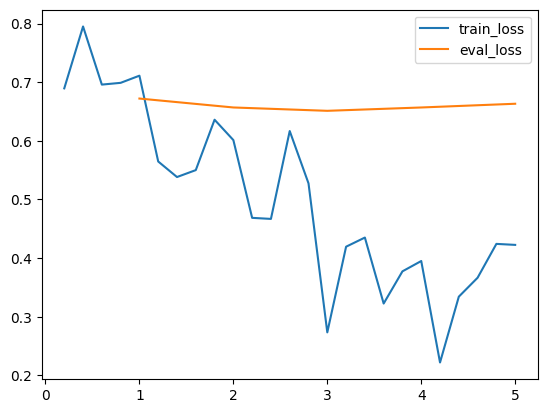

In [17]:
# Retrieve log_history and save it to a dataframe
log = pd.DataFrame(trainer.state.log_history)
log_t = log[log['loss'].notna()]
log_e = log[log['eval_loss'].notna()]

# Plot train and evaluation losses
plt.plot(log_t["epoch"], log_t["loss"], label = "train_loss")
plt.plot(log_e["epoch"], log_e["eval_loss"], label = "eval_loss")
plt.legend()
plt.show()

![image](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/7KEnvtpUyNcJTINdArLf7A/loss%20dpo.png)


In [18]:
# Load the trained DPO model you just trained
dpo_model = AutoModelForCausalLM.from_pretrained('./dpo/checkpoint-250')


#### Loading trained model


If you encounter difficulty in running the training cell due to resource limitations, you can download the model to be fine-tuned:


In [19]:
# Define the URL and the filename
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/YIDeT3qihEpWChdXN_RmTg/DPO-tar.gz'
filename = './DPO.tar'

# Download the file
response = requests.get(url)

# Save the file locally
with open(filename, 'wb') as f:
    f.write(response.content)

# Extract the tar file
if tarfile.is_tarfile(filename):
    with tarfile.open(filename, 'r') as tar:
        tar.extractall()
        print("Files extracted:", tar.getnames())
else:
    print("The adownloaded file is not a tar file.")

Files extracted: ['DPO', 'DPO/adapter_config.json', 'DPO/tokenizer_config.json', 'DPO/merges.txt', 'DPO/adapter_model.safetensors', 'DPO/special_tokens_map.json', 'DPO/training_args.bin', 'DPO/README.md', 'DPO/vocab.json']


Then, load it into the model for further inference:


In [20]:
# Load the trained DPO model tiy just trained
dpo_model = AutoModelForCausalLM.from_pretrained('./DPO')


### Generation


In [21]:
# Load the GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [22]:
# Set a seed for reproducibility
set_seed(42)


# Define the generation configuration for the DPO model
# This sets the parameters for text generation
generation_config = GenerationConfig(
        # Use sampling to generate diverse text
        do_sample=True,
        # Top-k sampling parameter
        top_k=1,
        # Temperature parameter to control the randomness of the generated text
        temperature=0.1,
        # Maximum number of new tokens to generate
        max_new_tokens=25,
        # Use the end-of-sequence token as the padding token
        pad_token_id=tokenizer.eos_token_id
    )

# Define the input prompt for text generation
PROMPT = "Is a higher octane gasoline better for your car?"
# Encode the prompt using the tokenizer
inputs = tokenizer(PROMPT, return_tensors='pt')

# Generate text using the DPO model
outputs = dpo_model.generate(**inputs, generation_config=generation_config)
# Decode the generated text and print it
print("DPO response:\t",tokenizer.decode(outputs[0], skip_special_tokens=True))

# Load the pre-trained GPT-2 model
gpt2_model = AutoModelForCausalLM.from_pretrained('gpt2')
# Generate text using the GPT-2 model
outputs = gpt2_model.generate(**inputs, generation_config=generation_config)
# Decode the generated text and print it
print("\nGPT2 response:\t",tokenizer.decode(outputs[0], skip_special_tokens=True))

DPO response:	 Is a higher octane gasoline better for your car?

The answer is yes. The higher octane gasoline is better for your car.

The higher octane gasoline

GPT2 response:	 Is a higher octane gasoline better for your car?

The answer is yes. The higher octane gasoline is more efficient and more fuel efficient.

The higher oct


Althought the model is trained on a small data for 5 epochs only, it can be seen that the response generated by the DPO-tuned model is more concise and straightforward.


# Exercise



### Exercise 1: Preprocess the `argilla/ultrafeedback-binarized-preferences-cleaned` Dataset


This data set comprises user-generated prompts along with corresponding responses categorized as either "chosen" or "rejected." It provides a rich source of binary feedback, making it ideal for training models to align with user preferences.


##### Load the data set from the `argilla/ultrafeedback-binarized-preferences-cleaned`


In [23]:
# TODO

dataset = load_dataset("argilla/ultrafeedback-binarized-preferences-cleaned")

README.md:   0%|          | 0.00/4.46k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/143M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60917 [00:00<?, ? examples/s]

<details>
    <summary>Click here for hint</summary>

```python
dataset = load_dataset("argilla/ultrafeedback-binarized-preferences-cleaned")
```

</details>


In [24]:
dataset['train']

Dataset({
    features: ['source', 'prompt', 'chosen', 'chosen-rating', 'chosen-model', 'rejected', 'rejected-rating', 'rejected-model'],
    num_rows: 60917
})

##### Set the variable cnt to 50 and then select the first 50 (cnt) examples to reduce the volume of data for resource limitations.


In [25]:
# TODO

cnt = 50  # You can adjust this count based on your requirements

# Select the first 5% of examples
dataset['train'] = dataset['train'].select(range(cnt))

<details>
    <summary>Click here for hint</summary>

```python
cnt = 50  # You can adjust this count based on your requirements

# Select the first 5% of examples
dataset['train'] = dataset['train'].select(range(cnt))
```

</details>


##### Create a function named `process` that takes a row of data as input. Within this function, remove unwanted columns such as `source, chosen-rating, chosen-model, rejected-rating, and rejected-model`. Then, use the map function to apply the process function to each row in the training data set.


In [26]:
# TODO

def process(row):
    # Delete unwanted columns
    del row["source"]
    del row["chosen-rating"]
    del row["chosen-model"]
    del row["rejected-rating"]
    del row["rejected-model"]

    # Retrieve the actual response text
    row["chosen"] = row["chosen"][-1]["content"]
    row["rejected"] = row["rejected"][-1]["content"]

    return row

# Apply the data processing function to the dataset
dataset['train'] = dataset['train'].map(
    process,
    num_proc=multiprocessing.cpu_count(),
    load_from_cache_file=False,
)

Map (num_proc=2):   0%|          | 0/50 [00:00<?, ? examples/s]

<details>
    <summary>Click here for hint</summary>

```python
def process(row):
    # Delete unwanted columns
    del row["source"]
    del row["chosen-rating"]
    del row["chosen-model"]
    del row["rejected-rating"]
    del row["rejected-model"]
    
    # Retrieve the actual response text
    row["chosen"] = row["chosen"][-1]["content"]
    row["rejected"] = row["rejected"][-1]["content"]
    
    return row

# Apply the data processing function to the dataset
dataset['train'] = dataset['train'].map(
    process,
    num_proc=multiprocessing.cpu_count(),
    load_from_cache_file=False,
)
```

</details>


##### Split the data set into training and evaluation sets:
Calculate the size for the training set as 80% of the total data. The remaining 20% will be used for evaluation.


In [27]:
# TODO

train_size = int(0.8 * len(dataset['train']))  # 80% for training
eval_size = len(dataset['train']) - train_size  # Remaining 20% for evaluation

train_dataset = dataset['train'].select(range(train_size))
eval_dataset = dataset['train'].select(range(train_size, train_size + eval_size))

<details>
    <summary>Click here for hint</summary>

```python
train_size = int(0.8 * len(dataset['train']))  # 80% for training
eval_size = len(dataset['train']) - train_size  # Remaining 20% for evaluation

train_dataset = dataset['train'].select(range(train_size))
eval_dataset = dataset['train'].select(range(train_size, train_size + eval_size))
```

</details>


In [28]:
train_dataset

Dataset({
    features: ['prompt', 'chosen', 'rejected'],
    num_rows: 40
})

In [29]:
train_dataset[0]

{'prompt': 'Can you write a C++ program that prompts the user to enter the name of a country and checks if it borders the Mediterranean Sea? Here\'s some starter code to help you out:\n#include <iostream>\n#include <string>\nusing namespace std;\nint main() {\n    string country;\n    // prompt user for input\n    cout << "Enter the name of a country: ";\n    cin >> country;\n    // check if country borders the Mediterranean Sea\n    // [C++ code]\n    return 0;\n}',
 'chosen': 'Here\'s a C++ program that prompts the user to enter the name of a country and checks if it borders the Mediterranean Sea:\n\n#include <iostream>\n#include <string>\n#include <set>\n#include <map>\n#include <algorithm>\n\nusing namespace std;\n\nint main() {\n    // store countries and their bordering seas in a map\n    map<string, set<string>> countries;\n    countries["Algeria"] = {"Mediterranean Sea", "North African Coast"};\n    countries["France"] = {"Mediterranean Sea", "English Channel"};\n    countries[

### Exercise 2: Prompt Inferencing and Comparison with GPT-2


In [30]:
PROMPT = input()

Top 10 biohacking trends?


##### Initialize the GPT-2 Tokenizer


In [31]:
# TODO

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

<details>
    <summary>Click here for hint</summary>

```python
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
```

</details>


##### Create a generation_config object to set the parameters for text generation.
- do_sample=True    (It enables sampling, which allows for more diverse outputs.)
- top_k=1 (It specifies the number of highest probability vocabulary tokens to consider during generation.)
- temperature=0.1 (It controls the randomness of the output.)
- max_new_tokens=25 (It sets the maximum number of new tokens to generate during inference.)
- pad_token_id=tokenizer.eos_token_id (It specifies the token to use for padding.)


In [32]:
#TODO

generation_config = GenerationConfig(
    # Use sampling to generate diverse text
    do_sample=True,
    # Top-k sampling parameter: controls the number of highest probability tokens to consider
    top_k=1,
    # Temperature parameter: controls the randomness of the generated text
    temperature=0.1,
    # Maximum number of new tokens to generate
    max_new_tokens=25,
    # Use the end-of-sequence token as the padding token
    pad_token_id=tokenizer.eos_token_id
)

<details>
    <summary>Click here for hint</summary>

```python
generation_config = GenerationConfig(
    # Use sampling to generate diverse text
    do_sample=True,
    # Top-k sampling parameter: controls the number of highest probability tokens to consider
    top_k=1,
    # Temperature parameter: controls the randomness of the generated text
    temperature=0.1,
    # Maximum number of new tokens to generate
    max_new_tokens=25,
    # Use the end-of-sequence token as the padding token
    pad_token_id=tokenizer.eos_token_id
)
```

</details>


##### Create a function named `generate_dpo_response` that takes a prompt as input and generates a response using the DPO model (`dpo_model`).


In [33]:
# TODO

def generate_dpo_response(prompt):
    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors='pt')

    # Generate text using the DPO model
    outputs = dpo_model.generate(**inputs, generation_config=generation_config)

    # Decode and return the response
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

<details>
    <summary>Click here for hint</summary>

```python
def generate_dpo_response(prompt):
    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors='pt')

    # Generate text using the DPO model
    outputs = dpo_model.generate(**inputs, generation_config=generation_config)
    
    # Decode and return the response
    return tokenizer.decode(outputs[0], skip_special_tokens=True)
```

</details>


##### Create another function named `generate_gpt2_response` that takes a prompt as input and generates a response using the GPT-2 model (`gpt2_model`).


In [34]:
# TODO

def generate_gpt2_response(prompt):
    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors='pt')

    # Generate text using the GPT-2 model
    outputs = gpt2_model.generate(**inputs, generation_config=generation_config)

    # Decode and return the response
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

<details>
    <summary>Click here for hint</summary>

```python
def generate_gpt2_response(prompt):
    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors='pt')

    # Generate text using the GPT-2 model
    outputs = gpt2_model.generate(**inputs, generation_config=generation_config)
    
    # Decode and return the response
    return tokenizer.decode(outputs[0], skip_special_tokens=True)
```

</details>


##### Call both functions with a prompt and compare the responses.


In [35]:
# TODO

# Generate responses
dpo_response = generate_dpo_response(PROMPT)
gpt2_response = generate_gpt2_response(PROMPT)

# Print the responses
print("DPO response:\t", dpo_response)
print("\nGPT-2 response:\t", gpt2_response)

DPO response:	 Top 10 biohacking trends?

The most popular biohacking trends are:

1. The use of biohacking tools to hack into

GPT-2 response:	 Top 10 biohacking trends?

The most popular biohacking trends are:

1. The use of biohacking tools to hack into




<details>
    <summary>Click here for hint</summary>

```python
# Generate responses
dpo_response = generate_dpo_response(PROMPT)
gpt2_response = generate_gpt2_response(PROMPT)

# Print the responses
print("DPO response:\t", dpo_response)
print("\nGPT-2 response:\t", gpt2_response)
```

</details>


# Congratulations! You have completed the lab!


## Authors


[Fateme Akbari](https://www.linkedin.com/in/fatemeakbari/) is a Ph.D. candidate in Information Systems at McMaster University with demonstrated research experience in Machine Learning and NLP.

[Kunal Makwana](https://author.skills.network/instructors/kunal_makwana) is a Data Scientist at IBM and is currently pursuing his Master's in Computer Science at Dalhousie University.


## References
[DPO Trainer](https://huggingface.co/docs/trl/main/en/dpo_trainer)


© Copyright IBM Corporation. All rights reserved.
